In [415]:
from IPython.display import display, Math, Latex,HTML
%matplotlib inline
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import math
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from glob import glob


In [423]:
model = gum.BayesNet()

nodeList = ["Economic",
           "Sponsor",
           "Refugee",
           "Total",
           "Worker",
           "Business"]

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

model.add(gum.LabelizedVariable('Province','Province',provinceLabel))

rangeNode = {"Worker":120,
             "Business":100,
             "Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
             "Total": 200
            }

coeff = {"Worker":100,
         "Business":10,
         "Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
         "Total": 1
        }
for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000

model.addArc('Economic','Total')
model.addArc('Sponsor','Total')
model.addArc('Refugee','Total')
model.addArc('Province','Sponsor')
model.addArc('Province','Refugee')
model.addArc('Province','Economic')
model.addArc('Worker','Economic')
model.addArc('Business','Economic')

model.addArc('Province','Worker')
model.addArc('Province','Business')

model

(pyAgrum.BayesNet<double>@000001CFF829F910) BN{nodes: 7, arcs: 10, domainSize: 10^13.2143, dim: 127723380, mem: 979Mo 663Ko 648o}

In [424]:
model.cpt("Province").fillWith(1).normalize()

df = {}

pr = {p:{d:0 for d in nodeList} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]
    
    for d in nodeList:
        arr = np.array(df[p][d])
        
        hist = np.histogram(arr, bins[d])[0]
        pr[p][d]=  hist

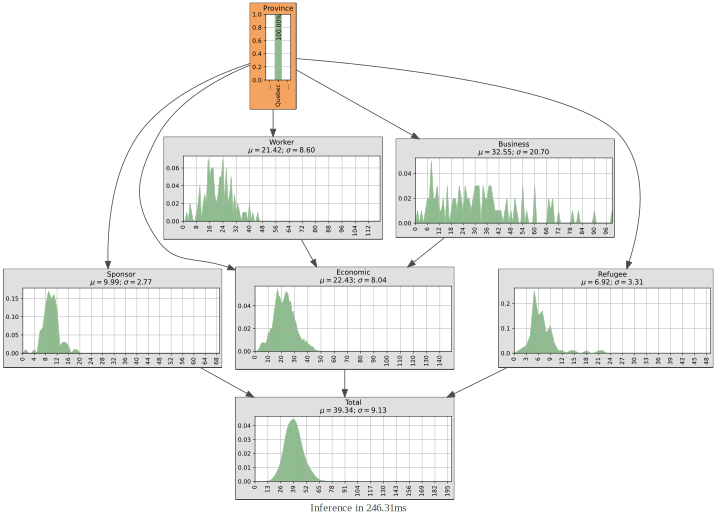

In [425]:
for index, p in enumerate(provinceLabel):
    model.cpt("Worker")[index] = pr[p]["Worker"]
    model.cpt("Business")[index] = pr[p]["Business"]
    
    model.cpt("Sponsor")[index] = pr[p]["Sponsor"]
    model.cpt("Refugee")[index] = pr[p]["Refugee"]

model.cpt("Total").fillWithFunction("(Sponsor+Economic+Refugee)")
model.cpt("Economic").fillWithFunction("round((Worker*100+Business*10)/110)")
gnb.showInference(model, evs={"Province":"Quebec"},size="10")

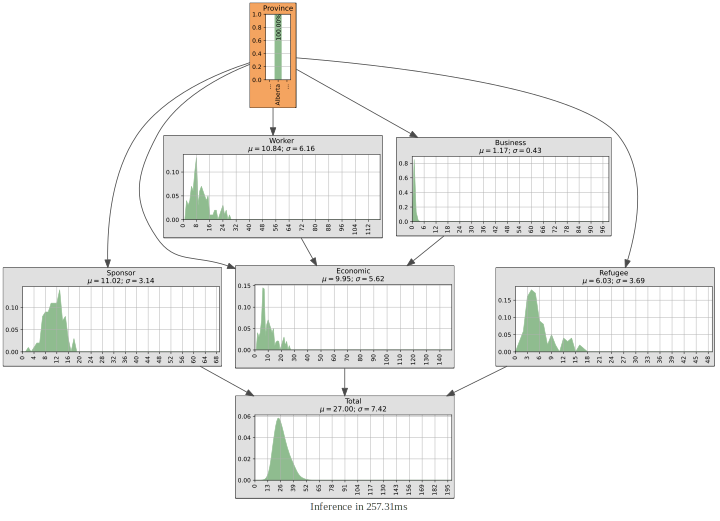

In [426]:
gnb.showInference(model, evs={"Province":"Alberta"},size="10")

In [429]:
model = gum.BayesNet()

nodeList = ["Economic",
             "Sponsor",
             "Refugee",
             "Total"
           ]

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in nodeList}

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]
provinceLabel = provinceLabel[:-3]
model.add(gum.LabelizedVariable('Province','Province',provinceLabel))

rangeNode = {"Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
             "Total": 200
            }

coeff = {"Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
         "Total": 1
        }
for n in nodeList:
    bins[n] = bins[n][:rangeNode[n]]
        
    model.add(gum.NumericalDiscreteVariable(n,n,bins[n]))
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000

model.addArc('Economic','Total')
model.addArc('Sponsor','Total')
model.addArc('Refugee','Total')
model.addArc('Province','Sponsor')
model.addArc('Province','Refugee')
model.addArc('Province','Economic')

model

(pyAgrum.BayesNet<double>@000001CFF829FEE0) BN{nodes: 5, arcs: 6, domainSize: 10^9.02119, dim: 104477679, mem: 801Mo 109Ko 688o}

In [654]:
model.cpt("Province").fillWith(1).normalize()
from sklearn.neighbors import KernelDensity

df = {}

pr = {p:{d:0 for d in rangeNode.keys()} for p in provinceLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]
    
    for d in nodeList:
        arr = np.array(df[p][d])
        
        hist = np.histogram(arr, bins[d])[0]
        pr[p][d]=  hist/sum(hist)
        
        #pr[p][d]=  sum(stats.norm(xi).pdf(np.linspace(0,25000,len(bins[d])-1)) for xi in hist)
        
        #kde = KernelDensity(bandwidth=100.0, kernel='gaussian')
       # kde.fit(arr[:, None])
        #x_d = np.linspace(0, 25000, len(bins[d])-1)
        #logprob = kde.score_samples(x_d[:, None])

        #pr[p][d]= np.exp(logprob)

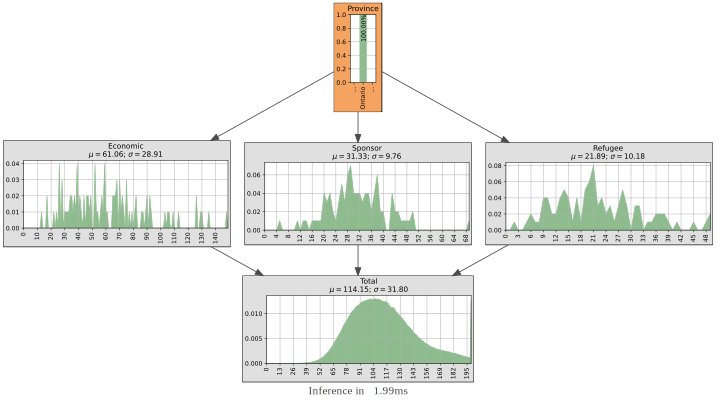

In [656]:
for index, p in enumerate(provinceLabel):
    model.cpt("Economic")[index] = pr[p]["Economic"]
    model.cpt("Sponsor")[index] = pr[p]["Sponsor"]
    model.cpt("Refugee")[index] = pr[p]["Refugee"]

model.cpt("Total").fillWithFunction("(Sponsor+Economic+Refugee)")
gnb.showInference(model, evs={"Province":"Ontario"},size="10")


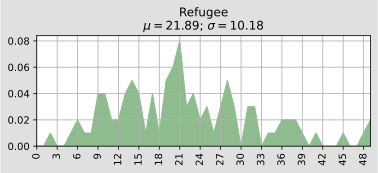

In [666]:
gnb.showPosterior(model,{"Province":"Ontario"},"Refugee")

In [668]:
def nodevalue(n):
    return 0.4 if n in "aeiou" else 6

import pyAgrum.lib.image as gumimage
gumimage.exportInference(model,"inference_ontario.pdf",targets={"Total"},evs={"Province":"Ontario"},nodeColor={n:nodevalue(n) for n in model.names()})

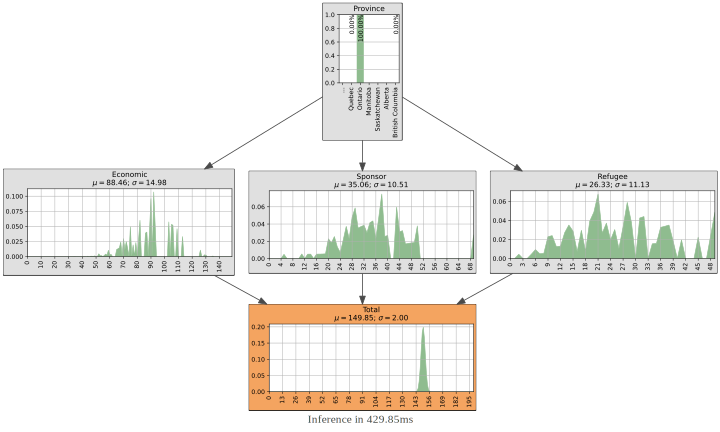

In [676]:
from scipy import stats
values = np.arange(0,200,1)
distribution = stats.norm.pdf(values,150,2)

def nodevalue(n):
    return 0.4 if n in "aeiou" else 1

gnb.showInference(model, evs={"Total":distribution},size="10")
gumimage.exportInference(model,"a.pdf", 
                         evs={"Total":distribution},
                         nodeColor={n:nodevalue(n) for n in model.names()})
gumimage.exportInference(model,"b.pdf",
                         targets={"Refugee"},
                         evs={"Total":distribution},
                         nodeColor={n:nodevalue(n) for n in model.names()})

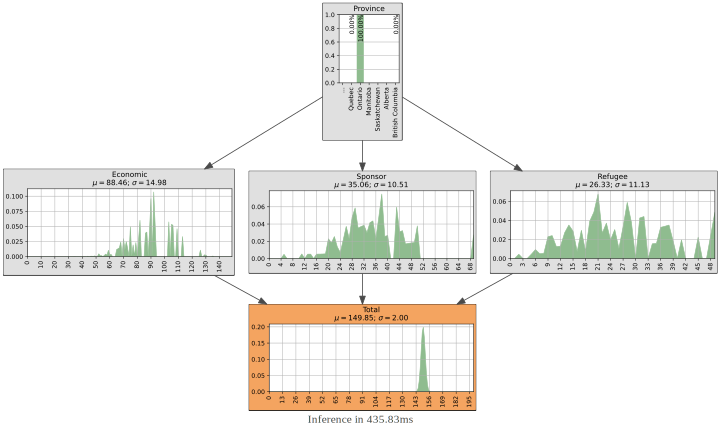

In [685]:
gnb.showInference(model, 
                  evs={"Total":distribution},
                  size="10",
                  arcWidth={(0, 1): 0.0,
                            (0, 2): 0.0,
                            (0, 3): 0.0,
                            (1, 4): 0.0,
                            (2, 4): 0.0,
                            (3, 4): 0.0}, graph={"Province"})



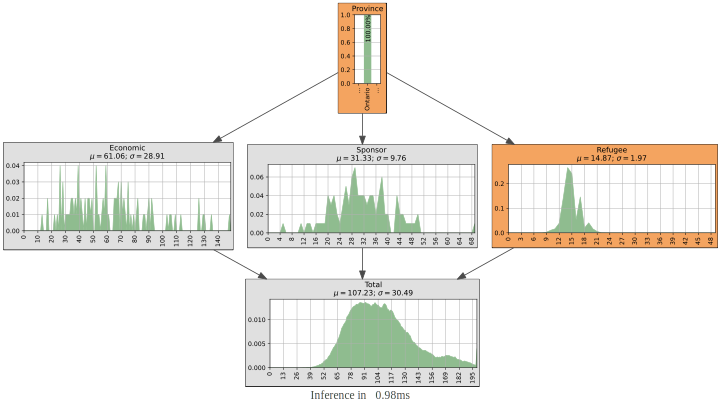

In [672]:

gnb.showInference(model, evs={"Province":"Ontario","Refugee":distribution},size="10")